# Методы анализа и обработки изображения

---

ЛР6 - Библиотека Scikit-Learn для анализа изображений / Машинное обучение

Студентка гр. РИМ-181226

Бабайлова Маргарита Леонидовна

In [1]:
from sklearn.datasets import load_digits, fetch_mldata, fetch_lfw_people,\
make_blobs
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from seaborn import heatmap
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,\
accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
from matplotlib import offsetbox
import seaborn as sns; sns.set()
from skimage import data, color, feature, transform
import skimage.data
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

Анализ рукописных цифр

Загрузка и визуализация цифр

In [3]:
digits = load_digits()
digits.images.shape

(1797, 8, 8)

Данные изображений представляют собой трехмерный массив: 1797 выборок, каждая состоит из сетки пикселов размером 8 × 8. Визуализация первой их сотни.

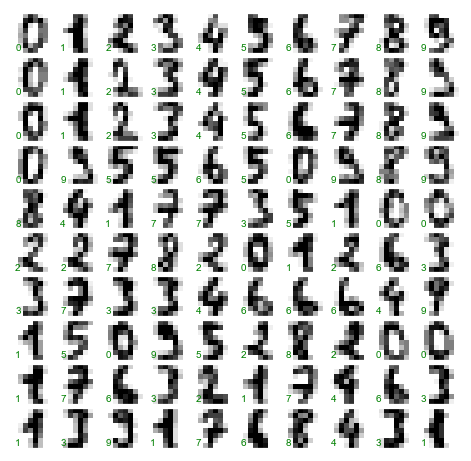

In [4]:
fig, axes = plt.subplots(10, 10, figsize = (8, 8),
                         subplot_kw = {'xticks': [], 'yticks': []},
                         gridspec_kw = dict(hspace = 0.1, wspace = 0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap = 'binary', interpolation = 'nearest')
    ax.text(0.05, 0.05, str(digits.target[i]), transform = ax.transAxes,\
            color = 'green')

Для работы с этими данными в библиотеке Scikit-Learn нужно получить их двумерное `[n_samples, n_features]` представление. 

Для этого каждый пиксель в изображении будет трактоваться как признак. То есть массивы пикселей будут "расплющены" так, чтобы каждую цифру представлял массив пикселей длиной 64 элемента. 

Кроме этого, необходим целевой массив, задающий для каждой цифры предопределенную метку. Эти два параметра встроены в набор данных цифр в виде атрибутов `data` и `target`, соответственно.

In [5]:
X = digits.data
X.shape

(1797, 64)

In [6]:
y = digits.target
y.shape

(1797,)

Итого 1797 выборок и 64 признака.

---

Обучение без учителя: понижение размерности

Хотелось бы визуализировать точки в 64-мерном параметрическом пространстве, но непросто эффективно визуализировать точки в пространстве такой высокой размерности. 

Необходимо понизить количество измерений до 2, воспользовавшись методом обучения без учителя. Здесь применяется алгоритм обучения на базе многообразий под названием `Isomap`.

Преобразуем данные в двумерный вид.

In [7]:
iso = Isomap(n_components = 2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

(1797, 2)

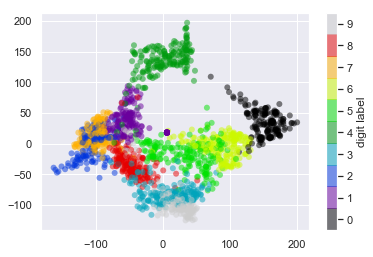

In [8]:
plt.scatter(data_projected[:, 0], data_projected[:, 1],
            c=digits.target, edgecolor = 'none', alpha = 0.5,
            cmap = plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar(label = 'digit label', ticks = range(10))
plt.clim(-0.5, 9.5);

Этот график дает представление о разделении различных цифр в 64-мерном пространстве. Например, нули (отображаемые черным цветом) и единицы (отображаемые фиолетовым) практически не пересекаются в параметрическом пространстве. На интуитивном уровне это представляется вполне логичным: нули содержат пустое место в середине изображения, а у единиц там, наоборот, чернила. 

С другой стороны, единицы и четверки на графике располагаются сплошным спектром, что понятно, ведь некоторые люди рисуют единицы со «шляпками», из-за чего они становятся похожи на четверки.

В целом различные группы достаточно хорошо разнесены в параметрическом пространстве. Это значит, что даже довольно простой алгоритм классификации с учителем должен работать на них достаточно хорошо.

---

Классификация цифр

Данные необходимо разбить на обучающую и контрольную последовательности, после чего на первой из них обучается модель наивного байесовского классификатора.

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 0)

In [10]:
model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

Теперь возможно оценить точность модели,  сравнив настоящие значения из контрольной последовательности с предсказанными.

In [11]:
accuracy_score(ytest, y_model)

0.8333333333333334

Получена более чем 80% точность классификации, однако из одного числа сложно понять, где наша модель ошиблась. Для этой цели удобна так называемая матрица различий `confusion matrix`, вычислить которую можно с помощью библиотеки `Scikit-Learn`, а нарисовать посредством `Seaborn`.

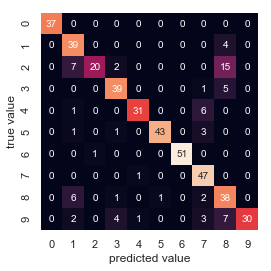

In [12]:
mat = confusion_matrix(ytest, y_model)
heatmap(mat, square = True, annot = True, cbar = False)
plt.xlabel('predicted value') # Прогнозируемое значение
plt.ylabel('true value');     # Настоящее значение

Этот рисунок демонстрирует места, в которых классификатор склонен ошибаться. Например, значительное количество двоек ошибочно классифицированы как единицы или восьмерки.

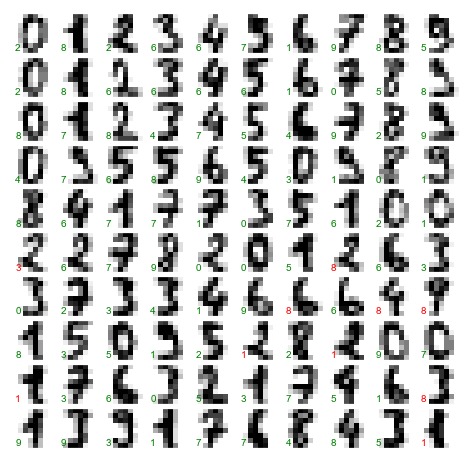

In [13]:
fig, axes = plt.subplots(10, 10, figsize = (8, 8),
                         subplot_kw = {'xticks':[], 'yticks':[]},
                         gridspec_kw = dict(hspace = 0.1, wspace = 0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_model[i]),
    transform=ax.transAxes,
    color='green' if (ytest[i] == y_model[i]) else 'red')

---

Распознавание лиц

В качестве примера работы метода опорных векторов рассматрим задачау распознавания лиц. 

Используется набор данных `Labeled Faces in the Wild1` (LFW), состоящий из нескольких тысяч упорядоченных фотографий различных общественных деятелей.

In [14]:
faces = fetch_lfw_people(min_faces_per_person = 60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


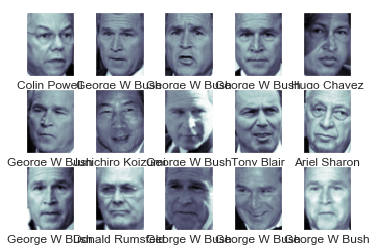

In [15]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap = 'bone')
    axi.set(xticks = [], yticks = [],
    xlabel = faces.target_names[faces.target[i]])

Каждое изображение содержит 62 × 47, то есть примерно 3000 пикселей. Можно рассматривать каждый пиксель как признак, но эффективнее использовать какой-либо препроцессор для извлечения более осмысленных признаков. В данном случае используется метод главных компонент для извлечения 150 базовых компонент, которые передаются классификатору на основе метода опорных векторов.

In [16]:
pca = PCA(n_components = 150, whiten = True, random_state = 42)
svc = SVC(kernel = 'rbf', class_weight = 'balanced')
model = make_pipeline(pca, svc)

Для контроля результатов работы классификатора данные разбиваются на
обучающую и контрольную последовательности.

In [17]:
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data,
                                                faces.target,
                                                random_state = 42)

С помощью поиска по сетке с перекрестной проверкой подбираются значения параметров `C` (управляющего размытием отступов) и `gamma` (управляющего размером ядра радиальной базисной функции) и определяется оптимальная модель.

In [18]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)
%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

Wall time: 29.3 s
{'svc__C': 10, 'svc__gamma': 0.001}


Теперь с помощью этой, подвергнутой перекрестной проверке модели можно предсказать метки для контрольных данных, которые модель еще не видела.

In [19]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

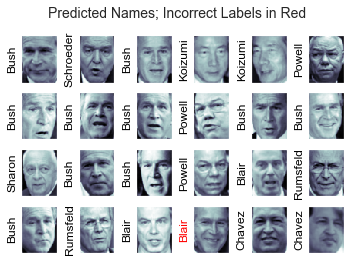

In [20]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap = 'bone') 
    axi.set(xticks = [], yticks = [])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color = 'black' if yfit[i] == ytest[i] else 'red')
    fig.suptitle('Predicted Names; Incorrect Labels in Red', size = 14);

В этой небольшой выборке оптимальный оцениватель ошибся для одного лица (лицо Дж. Буша в нижнем ряду было ошибочно помечено как лицо Блэра). 

Чтобы лучше понять эффективность работы оценивателя, используется отчет о классификации, в котором приведена статистика восстановления значений по каждой метке, и матрица различий между классами.


In [21]:
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

        micro avg       0.85      0.85      0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



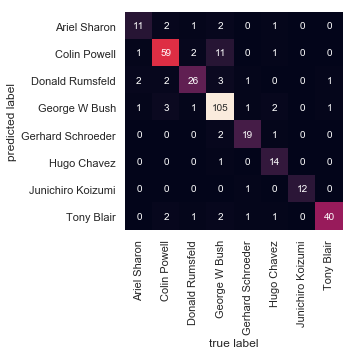

In [22]:
mat = confusion_matrix(ytest, yfit)
heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False,
        xticklabels=faces.target_names,
        yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

---
Использование случайного леса для классификации цифр

In [23]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

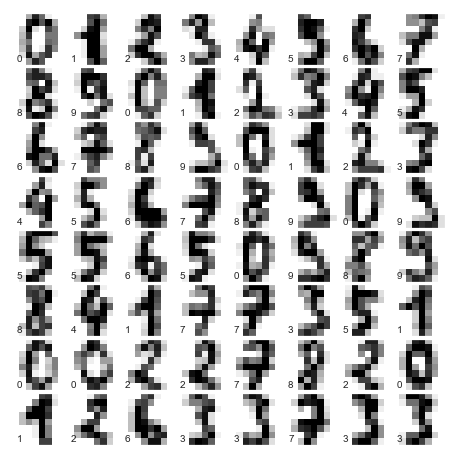

In [24]:
# Настройки рисунка
fig = plt.figure(figsize=(6, 6))  # размер рисунка в дюймах
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05,
wspace=0.05)
# Рисуем цифры: размер каждого изображения 8 x 8 пикселов
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # Маркируем изображение целевыми значениями
    ax.text(0, 7, str(digits.target[i]))

Применение классификатора на основе случайного леса.

In [25]:
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [26]:
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

   micro avg       0.98      0.98      0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



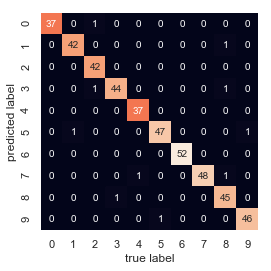

In [27]:
mat = confusion_matrix(ytest, ypred)
heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Простой, не настроенный специальным образом случайный лес дает точную классификацию данных по рукописным цифрам.

---

Использование `Isomap` для распознавания лиц

In [28]:
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

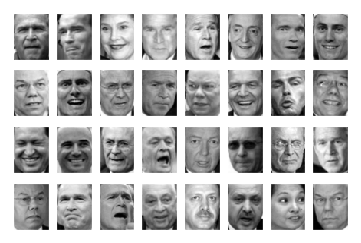

In [29]:
fig, ax = plt.subplots(4, 8, subplot_kw = dict(xticks = [], yticks = []))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap = 'gray')

Имеется 2370 изображений, каждое размером 2914 пикселей.

Необходимо вычислить PCA и изучить полученную долю объяснимой дисперсии, для получения  представления о том, сколько линейных признаков необходимо для описания этих данных.

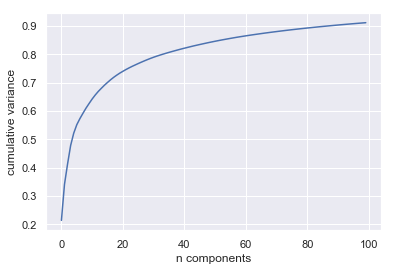

In [30]:
model = PCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')         # Количество компонент
plt.ylabel('cumulative variance'); # Интегральная дисперсия

Для сохранения 90 % дисперсии необходимо почти 100 компонент. Это значит, что данные, по своей сути, имеют чрезвычайно высокую размерность и их невозможно описать линейно с помощью всего нескольких компонент.

В подобном случае могут оказаться полезны нелинейные вложения на базе многообразий, такие как `LLE` и `Isomap`.

In [31]:
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

Результат представляет собой двумерную проекцию всех исходных изображений. Чтобы лучше представить, что содержит эта проекция, нужно вывести миниатюры изображений в местах проекций.

In [32]:
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # Не отображаем слишком близко расположенные точки
                continue
            shown_images = np.vstack([shown_images, proj[i]]) 
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage\
                                    (images[i], cmap=cmap), proj[i])
            ax.add_artist(imagebox)

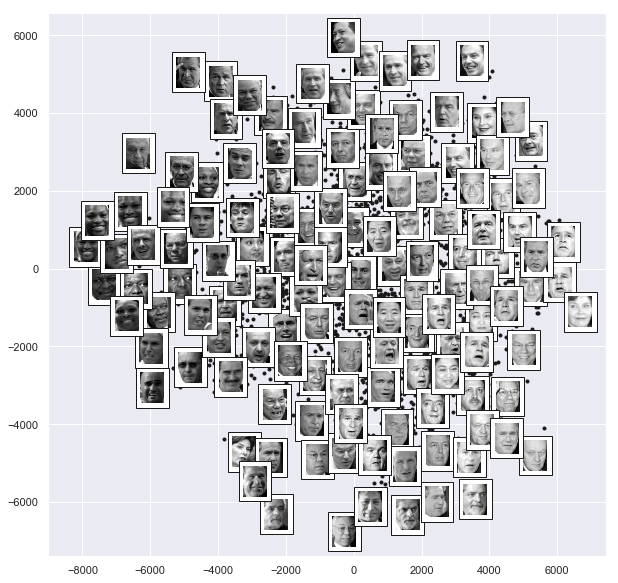

In [33]:
fig, ax = plt.subplots(figsize=(10, 10)) 
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

Результат интересен: первые два измерения `Isomap`, вероятно, описывают общие признаки изображения: низкую или высокую яркость изображения слева направо и общее расположение лица снизу вверх. Это дает общее представление о некоторых базовых признаках данных.

Далее возможно выполнение классификации этих данных.

---

Визуализация структуры цифр

In [34]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
mnist.data.shape

(70000, 784)

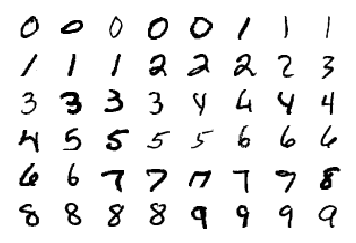

In [35]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

Необходимо вычислить, с помощью обучения на базе многообразий, проекцию для этих данных. Для ускорения используется только 1/30 часть данных, то есть примерно 2000 точек данных.

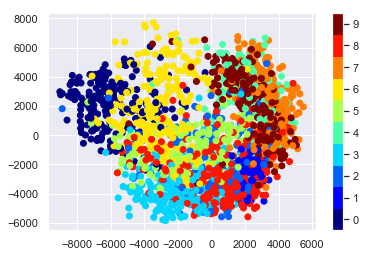

In [36]:
# используем только 1/30 часть данных:
# вычисления для полного набора данных занимают длительное время!
data = mnist.data[::30]
target = mnist.target[::30]
model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

Полученная диаграмма рассеяния демонстрирует некоторые зависимости между точками данных, но точки на ней расположены слишком тесно. Можно получить больше информации, изучая за раз данные лишь об одной цифре.

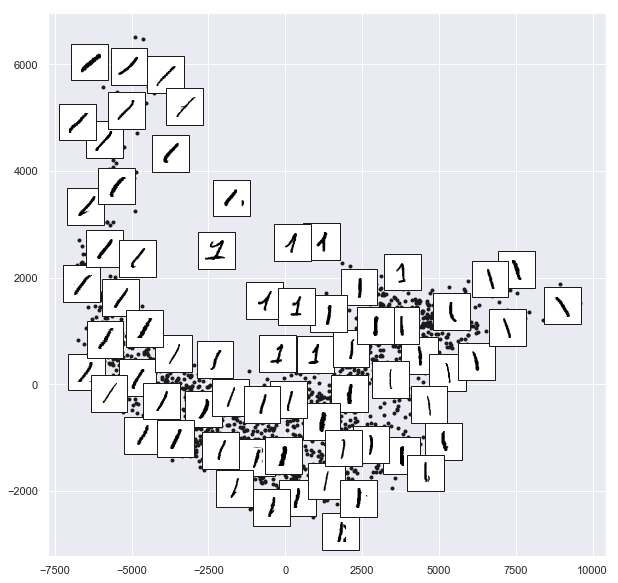

In [37]:
# Выбираем для проекции 1/4 цифр "1"
data = mnist.data[mnist.target == 1][::4]
fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

Результат дает представление о разнообразии форм, которые может принимать цифра 1 в этом наборе данных. Данные располагаются вдоль широкой кривой в пространстве проекции, отражающей ориентацию цифры. При перемещении вверх по графику видны единицы со «шляпками» и/или «подошвами», хотя они в этом наборе данных редки. Проекция дает возможность обнаружить аномальные значения с проблемами в данных (например, части соседних цифр, попавших в извлеченные изображения).

Хотя само по себе для задачи классификации цифр это и не особо полезно, но может помочь получить представление о данных и подсказать, что делать дальше, например какой предварительной обработке необходимо подвергнуть данные до создания конвейера классификации.

---

Конвейер распознавания лиц

Для разработки конвейера испрользуется методика выделения признаков – гистограмма направленных градиентов `histogram of oriented gradients` HOG, которая преобразует пиксели изображения в векторное представление, чувствительное к несущим информацию признакам изображения, без учета таких факторов, как освещенность.

Гистограмма направленных градиентов — простая процедура выделения признаков, разработанная для идентификации пешеходов на изображениях. 

Метод HOG включает следующие этапы:

1. Необязательная предварительная нормализация изображений. В результате получаются признаки, слабо зависящие от изменений освещенности.
2. Операция свертывания изображения с помощью двух фильтров, чувствительных к горизонтальным и вертикальным градиентам яркости. Это позволяет уловить информацию о границах, контурах и текстурах изображения.
3. Разбивка изображения на ячейки заранее определенного размера и вычисление гистограммы направлений градиентов в каждой из ячеек.
4. Нормализация гистограмм в каждой из ячеек путем сравнения с несколькими близлежащими ячейками. Это еще больше подавляет влияние освещенности на изображение.
5. Формирование одномерного вектора признаков из информации по каждой ячейке.

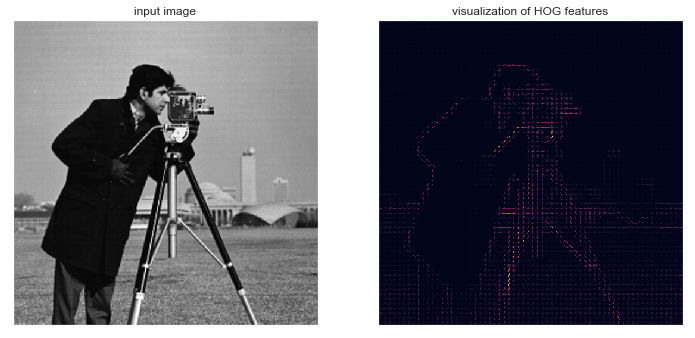

In [38]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.camera())
hog_vec, hog_vis = feature.hog(image, visualise=True)
fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                              subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')
ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');


Простой детектор лиц

На основе этих признаков `HOG` можно создать простой алгоритм обнаружения лиц с помощью любого из оценивателей библиотеки `Scikit-Learn`, например,  линейного метода опорных векторов. 

Алгоритм включает следующие шаги:
1. Получение миниатюр изображений, на которых представлены лица, для формирования набора «положительных» обучающих выборок.
2. Получение миниатюр изображений, на которых не представлены лица для формирования набора «отрицательных» обучающих выборок.
3. Выделение HOG-признаков из этих обучающих выборок.
4. Обучение линейного SVM-классификатора на этих выборках.
5. В случае «незнакомого» изображения перемещаем по изображению скользящее окно, применяя нашу модель для определения того, содержится ли в этом окне лицо или нет.
6. Если обнаруженные лица частично пересекаются, объединяем их в одно окно.

Получение набора положительных обучающих выборок

In [39]:
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

Получена пригодная для обучения выборка из 13233 изображений лиц.

---
Получение набора отрицательных обучающих выборок:

Необходимо найти набор миниатюр такого же размера, на которых не изображены лица. Чтобы сделать это, можно взять любой корпус исходных изображений и извлечь из них миниатюры в различных масштабах.

Здесь используются некоторые из поставляемых вместе с пакетом `Scikit-Image` изображения.

In [40]:
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [41]:
def extract_patches(img, N, scale=1.0,
                    patch_size=positive_patches[0].shape):
    extracted_patch_size = \
    tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size,\
                                             mode='constant')
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                       for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

Теперь есть 30 000 подходящих фрагментов изображений, не содержащих лиц.

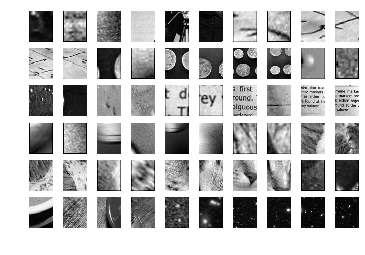

In [42]:
fig, ax = plt.subplots(6, 10) 
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray') 
    axi.axis('off')

Объединение наборов и выделение HOG-признаков

In [44]:
X_train = np.array([feature.hog(im)
                              for im in chain(positive_patches,
                                              negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

Обучение метода опорных векторов

Сначала используется Гауссов наивный байесовский классификатор, чтобы было с чем сравнивать.

In [45]:
cross_val_score(GaussianNB(), X_train, y_train)

array([0.94073971, 0.8751648 , 0.93949067])

Наивный байесовский алгоритм достигает более чем 90%-ной точности. 

Теперь используется метод опорных векторов с поиском по сетке из нескольких вариантов параметра C.

In [46]:
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.9866768440774408

In [47]:
grid.best_params_

{'C': 4.0}

Обучение оптимального оценивателя на полном наборе данных.

In [48]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=4.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Выполняем поиск лиц в новом изображении

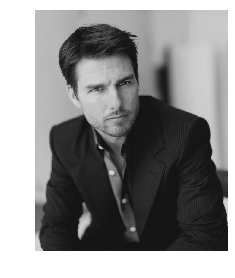

In [49]:
from skimage.io import imsave,imshow,imread
img1 = imread('man.jpg',1)
imshow(img1)
plt.axis('off');

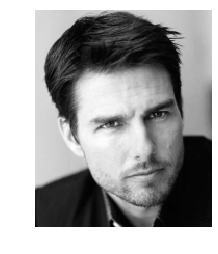

In [50]:
test_image = img1
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[20:230, 30:200]
plt.imshow(test_image, cmap='gray')
plt.axis('off');

Создание окна, которое будет перемещаться по фрагментам этого изображения с вычислением HOG-признаков для каждого фрагмента.

In [51]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(3996, 1215)

Использование этих фрагментов, для которых вычислены признаки HOG, и модели, чтобы определить, содержат ли какие-то из них лица.

In [52]:
labels = model.predict(patches_hog)
labels.sum()

121.0

Таким образом, среди 3996 фрагментов найдено 121 лицо. 

Используем имеющуюся о фрагментах информациию, чтобы определить, где в контрольном изображении они располагаются, нарисовав их границы в виде прямо- угольников.

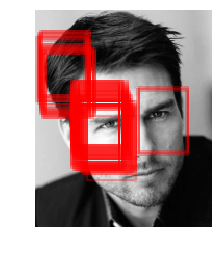

In [53]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))